#Data Analysis

The following notebook is how the data for the "A Bioinformatics Overview of Publicly Available Fanconi Anemia Mutation Data" report was analyzed following the extraction and processing in `reproduce1.sh` on [the repository](https://github.com/lazobax/capstone).

The required datafiles for this analysis are `data/combined/combined.normalized.num.vcf` and ` data/finalAnnot.tsv`. These are outputted by the aforementioned script and correspond to the inputs and outputs of ANNOVAR.

In [151]:
import pandas as pd

vcf = pd.read_csv('finalVCF.vcf', sep='\t', header=0, names=["CHROM", "POS", "ID", "REF", "ALT", "FILTER", "QUAL", "INFO"], comment="#", index_col=None)
finalAnnot = pd.read_csv('finalAnnot.tsv', sep='\t')

<ipython-input-151-9e03da0faf91>:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vcf = pd.read_csv('finalVCF.vcf', sep='\t', header=0, names=["CHROM", "POS", "ID", "REF", "ALT", "FILTER", "QUAL", "INFO"], comment="#", index_col=None)
<ipython-input-151-9e03da0faf91>:4: DtypeWarning: Columns (0,120) have mixed types. Specify dtype option on import or set low_memory=False.
  finalAnnot = pd.read_csv('finalAnnot.tsv', sep='\t')


In [152]:
vcf.shape, finalAnnot.shape

((91720, 8), (91721, 128))

We have an off by one size in the data, probably the header row.

#Variant Data Frame Processing and Analysis

Extracting Gene and Consequence from the INFO column.

In [153]:
import pandas as pd
import re

def extract_info(info_string):
    info_dict = {}
    for item in info_string.split(';'):
        if '=' in item:
            key, value = item.split('=', 1)
            info_dict[key] = value
    return info_dict

def extract_gene(id_string):
    match = re.search(r"\.([^.]+)(\d{5})$", id_string)
    if match:
        return match.group(1)
    else:
        return None

def extract_db(id_string):
    return id_string.split('.')[0]


vcf[['CONSEQ', 'REPORTED']] = vcf['INFO'].str.extract(r'CONSEQ=([^;]+);REPORTED=(\d+)')
vcf['GENE'] = vcf['ID'].apply(extract_gene)
vcf['REPORTED'] = pd.to_numeric(vcf['REPORTED'], errors='coerce')
vcf['DB'] = vcf['ID'].apply(extract_db)

vcf = vcf.drop('INFO',axis=1)


In [154]:
vcf.shape

(91720, 11)

Here, we will keep the orignal couns of each consequence for later use.

In [155]:
original_conseq_counts = vcf['CONSEQ'].value_counts()

This following mapping was done by manual selection from `scripts/label.py`. The consequence column will be renamed to only include `pathogenic`, `benign`, and `VUS`.

In [156]:
map = {'Pathogenic': 'pathogenic', 'benign': 'benign', 'Benign': 'benign', 'Uncertain significance': 'VUS', 'benign, VUS': 'benign', 'Likely benign': 'benign', 'Conflicting classifications of pathogenicity': 'VUS', 'VUS': 'VUS', 'Benign/Likely benign': 'benign', 'likely benign': 'benign', 'benign, likely benign, VUS': 'benign', '-': 'VUS', 'nan': 'VUS', 'likely benign, VUS': 'benign', 'pathogenic, VUS': 'pathogenic', 'Likely pathogenic': 'pathogenic', 'benign, NA': 'benign', 'pathogenic (dominant)': 'pathogenic', 'NA, VUS': 'VUS', 'pathogenic, pathogenic (dominant)': 'pathogenic', 'not provided': 'VUS', 'NA, pathogenic, pathogenic (dominant)': 'pathogenic', 'NA, pathogenic, VUS': 'pathogenic', 'Pathogenic/Likely pathogenic': 'pathogenic', 'pathogenic': 'pathogenic', 'pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'likely benign, NA': 'benign', 'likely pathogenic': 'pathogenic', 'likely pathogenic (dominant), NA': 'pathogenic', 'likely pathogenic, VUS': 'pathogenic', 'likely pathogenic, NA': 'pathogenic', 'likely pathogenic, NA, pathogenic, VUS': 'pathogenic', 'likely pathogenic (dominant), pathogenic, pathogenic (dominant)': 'pathogenic', 'benign, NA, VUS': 'benign', 'likely pathogenic (dominant)': 'pathogenic', 'NA, pathogenic': 'pathogenic', 'likely pathogenic, NA, pathogenic, pathogenic (dominant)': 'pathogenic', 'pathogenic (dominant), VUS': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant), NA, pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'likely benign, likely pathogenic (dominant), pathogenic, VUS': 'pathogenic', 'benign, likely benign': 'benign', 'benign, likely benign, NA, VUS': 'benign', 'likely pathogenic, pathogenic, pathogenic (dominant)': 'pathogenic', 'likely pathogenic (dominant), pathogenic': 'pathogenic', 'likely benign, NA, VUS': 'benign', 'likely pathogenic, pathogenic (dominant)': 'pathogenic', 'likely pathogenic, pathogenic': 'pathogenic', 'benign, NA, pathogenic, pathogenic (dominant), VUS': 'VUS', 'NA, pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'benign, likely pathogenic': 'VUS', 'likely pathogenic, pathogenic, VUS': 'pathogenic', 'likely pathogenic (dominant), NA, pathogenic, pathogenic (dominant)': 'pathogenic', 'no classification for the single variant': 'VUS', 'likely pathogenic (dominant), pathogenic (dominant)': 'pathogenic', 'likely pathogenic (dominant), NA, VUS': 'pathogenic', 'likely pathogenic (dominant), NA, pathogenic': 'pathogenic', 'benign, likely benign, NA': 'benign', 'likely pathogenic (dominant), NA, pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'likely pathogenic (dominant), pathogenic, VUS': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant), pathogenic': 'pathogenic', 'likely pathogenic, NA, pathogenic': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant), NA, pathogenic, pathogenic (dominant)': 'pathogenic', 'likely pathogenic, NA, pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'benign, likely benign, NA, pathogenic (dominant), VUS': 'VUS', 'likely benign, likely pathogenic': 'VUS', 'NA, pathogenic (dominant)': 'pathogenic', 'likely pathogenic, pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'likely benign (!), NA, VUS': 'benign', 'benign, pathogenic': 'VUS', 'VUS (!)': 'VUS', 'benign, likely benign, likely pathogenic, VUS': 'VUS', 'likely pathogenic (dominant), pathogenic, pathogenic (dominant), VUS': 'pathogenic', 'likely benign, likely pathogenic, likely pathogenic (dominant), VUS': 'VUS', 'likely benign, NA, pathogenic, VUS': 'VUS', 'likely benign (dominant), NA, VUS': 'benign', 'likely benign, pathogenic, VUS': 'VUS', 'benign, likely benign, NA, VUS, VUS (!)': 'benign', 'likely benign, likely pathogenic, VUS': 'VUS', 'benign, likely pathogenic (dominant), NA, VUS': 'VUS', 'benign, likely benign, NA, pathogenic, VUS': 'VUS', 'likely benign (dominant), VUS': 'benign', 'benign, likely benign, likely pathogenic, NA, VUS': 'VUS', 'likely benign, pathogenic, pathogenic (dominant)': 'VUS', 'pathogenic (!)': 'pathogenic', 'benign, likely benign, pathogenic, VUS': 'VUS', 'likely benign, likely pathogenic, pathogenic, VUS': 'VUS', 'likely pathogenic (dominant), NA, pathogenic, VUS': 'pathogenic', 'likely pathogenic, NA, VUS': 'pathogenic', 'likely pathogenic (dominant), NA, pathogenic (dominant)': 'pathogenic', 'likely pathogenic (dominant), VUS': 'pathogenic', 'likely pathogenic, pathogenic (recessive)': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant), NA': 'pathogenic', 'benign, likely benign, likely pathogenic': 'VUS', 'benign, likely pathogenic, NA, pathogenic, VUS': 'VUS', 'likely pathogenic, likely pathogenic (dominant), NA, VUS': 'pathogenic', 'benign, likely pathogenic (dominant), NA, pathogenic, pathogenic (dominant)': 'VUS', 'benign, likely benign, likely pathogenic, NA': 'VUS', 'likely benign, pathogenic': 'VUS', 'NA, pathogenic (!)': 'pathogenic', 'benign, likely benign, NA, pathogenic': 'VUS', 'NA, pathogenic (dominant), VUS': 'pathogenic', 'benign, likely pathogenic (dominant), NA, pathogenic, pathogenic (dominant), VUS': 'VUS', 'benign, pathogenic, pathogenic (dominant)': 'VUS', 'benign, likely pathogenic, NA, VUS': 'VUS', 'likely pathogenic, likely pathogenic (dominant), NA, pathogenic, VUS': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant)': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant), NA, pathogenic': 'pathogenic', 'likely pathogenic, likely pathogenic (dominant), NA, pathogenic (dominant), VUS': 'pathogenic', 'likely pathogenic (!), NA, VUS': 'pathogenic', 'likely benign, likely pathogenic, NA': 'VUS', 'likely benign, likely pathogenic, NA, VUS': 'VUS', 'pathogenic (dominant), pathogenic (recessive)': 'pathogenic', 'pathogenic, pathogenic (recessive)': 'pathogenic', 'pathogenic (recessive)': 'pathogenic', 'benign, likely benign, pathogenic (recessive), VUS': 'VUS', 'likely pathogenic, pathogenic, pathogenic (recessive), VUS': 'pathogenic', 'likely pathogenic (recessive)': 'pathogenic', 'benign, likely benign, pathogenic (recessive)': 'VUS', 'likely pathogenic (recessive), VUS': 'pathogenic', 'pathogenic (recessive), VUS': 'pathogenic', 'benign, pathogenic (recessive)': 'VUS', 'likely pathogenic, pathogenic, pathogenic (recessive)': 'pathogenic', 'likely pathogenic (recessive), pathogenic, pathogenic (recessive), VUS': 'pathogenic', 'likely pathogenic (recessive), pathogenic (recessive)': 'pathogenic', 'likely benign, pathogenic (recessive), VUS': 'VUS', 'pathogenic, pathogenic (recessive), VUS': 'pathogenic', 'likely benign, pathogenic (recessive)': 'VUS', 'likely pathogenic (recessive), pathogenic': 'pathogenic', 'benign, likely benign, pathogenic': 'VUS', 'NA, pathogenic (recessive)': 'pathogenic', 'likely pathogenic (recessive), NA, pathogenic, pathogenic (recessive), VUS': 'pathogenic', 'likely pathogenic (recessive), pathogenic, pathogenic (recessive)': 'pathogenic', 'likely pathogenic, NA, pathogenic (recessive)': 'pathogenic', 'NA, pathogenic, pathogenic (recessive)': 'pathogenic', 'likely pathogenic (!)': 'pathogenic', 'pathogenic, pathogenic (!), pathogenic (dominant)': 'pathogenic', 'Likely pathogenic, low penetrance': 'pathogenic', 'NA, pathogenic (recessive), VUS': 'pathogenic', 'NA, pathogenic, pathogenic (recessive), VUS': 'pathogenic'}

In [157]:
vcf_mapped = vcf.copy()
vcf_mapped['CONSEQ'] = vcf_mapped['CONSEQ'].map(map).fillna('VUS')

In [158]:
vcf_mapped.shape

(91720, 11)

In [159]:
modified_conseq_counts = vcf_mapped['CONSEQ'].value_counts()

In [160]:
vcf_mapped.columns

Index(['CHROM', 'POS', 'ID', 'REF', 'ALT', 'FILTER', 'QUAL', 'CONSEQ',
       'REPORTED', 'GENE', 'DB'],
      dtype='object')

## Reconciling Common and Duplicated Entires

The following will combine the duplicated records *within the **same** database*.

In [161]:
# Function to resolve CONSEQ: if multiple values, prefer non-VUS
def resolve_conseq(conseqs):
    unique_vals = list(dict.fromkeys(conseqs))  # preserve order
    if len(unique_vals) == 1:
        return unique_vals[0]
    # prefer first non-VUS
    for c in unique_vals:
        if c.lower() != 'vus':
            return c
    return unique_vals[0]

# Merge duplicates by DB, summing REPORTED and resolving CONSEQ
vcf_deduped = (
    vcf_mapped
    .groupby(['CHROM', 'POS', 'REF', 'ALT', 'DB'], as_index=False)
    .agg({
        'REPORTED': 'sum',
        'CONSEQ': lambda x: resolve_conseq(x.tolist()),
        'ID': 'first',
        'FILTER': 'first',
        'QUAL': 'first',
        'GENE': 'first'
    })
)

vcf_deduped.shape

(91710, 11)

We lost some.



Here’s what the script is doing, in everyday terms:

1. **Figuring out which variants appear where**
   It looks at each unique position-and-allele combination (your CHROM–POS–REF–ALT “keys”) and checks whether it shows up in just one database (CV or LOVD) or in both.

2. **Pulling out the “only-in-one” variants**

   * If a variant is found only in CV, it goes into `cv_only_df` unchanged.
   * If it’s found only in LOVD, it goes into `lovd_only_df`.

3. **Pulling out the “in-both” variants and side-by-side comparison**
   All variants that appear in both CV and LOVD are reshaped (“pivoted”) so that you get one row per variant but with two sets of columns: one set ending in `_CV` and one set ending in `_LOVD`. That way you can directly compare their annotations, counts, and so on.

4. **Classifying the shared variants**

   * **Concordant**: both databases gave the same clinical consequence (e.g. both said “pathogenic”).
   * **Semi-conflicting**: one said “VUS” and the other said “pathogenic” or “benign.”
   * **Totally conflicting**: one said “pathogenic” and the other “benign.”

5. **Resolving each class**

   * **Concordant**: merge them into one record, tag it as coming from “BOTH,” and add up their reported-count fields.
   * **Semi-conflicting**: keep the informative call (the one that isn’t “VUS”), tag it “BOTH,” and sum their reported counts.
   * **Total conflicts**: drop them—they’re too contradictory to reconcile here.

6. **Putting it all together**
   Finally, it stitches back together your CV-only variants, LOVD-only variants, the merged concordant variants, and the resolved semi-conflicts into one tidy DataFrame called `vcf_final`. Now you have a clean, non-redundant table where:

   * Unique variants stay as they were
   * Perfectly matching variants are collapsed into a single “BOTH” record
   * VUS vs. P/B cases are resolved in favor of the P or B call
   * Unresolvable P vs. B disagreements are omitted altogether.


In [162]:
import pandas as pd
import numpy as np

vcf_mapped = vcf_deduped

# define the key columns
keys = ['CHROM', 'POS', 'REF', 'ALT']

# 1) count how many distinct DBs each variant has
db_counts = vcf_mapped.groupby(keys)['DB'].nunique()

# 2) identify common vs unique variants
common_keys = db_counts[db_counts == 2].index
unique_keys = db_counts[db_counts == 1].index

# 3) extract unique variants
unique_df = (
    vcf_mapped
    .set_index(keys)
    .loc[unique_keys]
    .reset_index()
)
lovd_only_df = unique_df[unique_df['DB'] == 'LOVD']
cv_only_df   = unique_df[unique_df['DB'] == 'CV']

# 4) extract and pivot common variants
common_raw = (
    vcf_mapped
    .set_index(keys)
    .loc[common_keys]
    .reset_index()
)
common_df = (
    common_raw
    .pivot_table(index=keys, columns='DB', aggfunc='first')
)
# flatten MultiIndex columns
common_df.columns = [f"{col}_{db}" for col, db in common_df.columns]
common_df = common_df.reset_index()

# 5) define conflict masks
cv_cons = common_df['CONSEQ_CV'].str.lower()
lv_cons = common_df['CONSEQ_LOVD'].str.lower()
mask_concordant = cv_cons == lv_cons
mask_semi = (
    ((cv_cons == 'vus') & lv_cons.isin(['pathogenic','benign'])) |
    ((lv_cons == 'vus') & cv_cons.isin(['pathogenic','benign']))
)
mask_total_conflict = (
    ((cv_cons == 'pathogenic') & (lv_cons == 'benign')) |
    ((lv_cons == 'pathogenic') & (cv_cons == 'benign'))
)

# 6) split common into types
common_semi_conflicting  = common_df[mask_semi].reset_index(drop=True)
common_total_conflict    = common_df[mask_total_conflict].reset_index(drop=True)
common_concordant = common_df[mask_concordant].reset_index(drop=True)

# 7) process splits for final
# 7a) concordant: merge rows, set DB='BOTH', sum REPORTED
vcf_concordant = common_concordant.assign(
    DB='BOTH',
    CONSEQ=lambda df: df['CONSEQ_CV'],
    ID=lambda df: df['ID_CV'],
    FILTER=lambda df: df['FILTER_CV'],
    QUAL=lambda df: df['QUAL_CV'],
    GENE=lambda df: df['GENE_CV'],
    REPORTED=lambda df: df['REPORTED_CV'] + df['REPORTED_LOVD']
)[['CHROM','POS','ID','REF','ALT','FILTER','QUAL','CONSEQ','REPORTED','GENE','DB']]

# 7b) semi-conflict: pick non-VUS, set DB='BOTH', sum REPORTED
df_semi = common_semi_conflicting.copy()
cv_is_vus = df_semi['CONSEQ_CV'].str.lower() == 'vus'
df_semi = df_semi.assign(
    DB='BOTH',
    CONSEQ=lambda df: np.where(cv_is_vus, df['CONSEQ_LOVD'], df['CONSEQ_CV']),
    ID=lambda df: np.where(cv_is_vus, df['ID_LOVD'],      df['ID_CV']),
    FILTER=lambda df: np.where(cv_is_vus, df['FILTER_LOVD'],  df['FILTER_CV']),
    QUAL=lambda df: np.where(cv_is_vus, df['QUAL_LOVD'],    df['QUAL_CV']),
    GENE=lambda df: np.where(cv_is_vus, df['GENE_LOVD'],    df['GENE_CV']),
    REPORTED=lambda df: df['REPORTED_CV'] + df['REPORTED_LOVD']
)[['CHROM','POS','ID','REF','ALT','FILTER','QUAL','CONSEQ','REPORTED','GENE','DB']]

vcf_semi = df_semi

# 7c) total conflict: drop completely (no output)

# 8) assemble final vcf_final
vcf_final = pd.concat(
    [cv_only_df, lovd_only_df, vcf_concordant, vcf_semi],
    ignore_index=True
)[['CHROM','POS','ID','REF','ALT','FILTER','QUAL','CONSEQ','REPORTED','GENE','DB']]



In [163]:
vcf.shape, vcf_final.shape ,lovd_only_df.shape, cv_only_df.shape, common_semi_conflicting.shape, common_concordant.shape

((91720, 11), (76605, 11), (3861, 11), (57657, 11), (2508, 16), (12579, 16))

In [164]:
vcf['REPORTED'].sum(), vcf_final['REPORTED'].sum(), common_total_conflict["REPORTED_CV"].sum(), common_total_conflict["REPORTED_LOVD"].sum()

(np.int64(277770), np.int64(277721), np.int64(35), np.int64(14))

Everything makes sense.

In [165]:
# Filter for groups with >1 ALT and both 'pathogenic' & 'benign' CONSEQ (excluding VUS)
vcf_subset = vcf_final.groupby(['CHROM', 'POS', 'REF']).filter(
    lambda grp: grp['ALT'].nunique() > 1
        and {'pathogenic', 'benign'}.issubset(set(grp['CONSEQ'].str.lower()))
)

# Keep only rows whose CONSEQ is 'pathogenic' or 'benign'
vcf_subset = vcf_subset[
    vcf_subset['CONSEQ'].str.lower().isin(['pathogenic', 'benign'])
]


# Pivot so each CONSEQ becomes its own set of columns
vcf_wide = vcf_subset.pivot_table(
    index=['CHROM','POS','REF'],
    columns='CONSEQ',
    values=['ALT','ID','FILTER','QUAL','REPORTED','GENE'],
    aggfunc='first'
)

# Flatten MultiIndex column names (e.g., ALT_benign, ALT_pathogenic)
vcf_wide.columns = [f"{field}_{conseq.lower()}" for field, conseq in vcf_wide.columns]
vcf_wide = vcf_wide.reset_index()



### Overlap Diagram

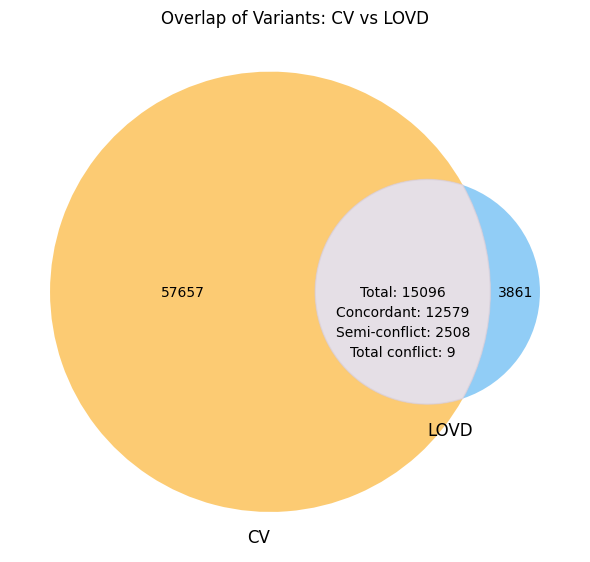

In [166]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Define colors
orange = '#faa916'   # Orange (web)
blue = '#48acf0'     # Argentinian Blue
thistle = '#d5cad6'  # Thistle

# Calculate counts
cv_only        = len(cv_only_df)
lovd_only      = len(lovd_only_df)
common_total   = len(common_df)
total_conflict = len(common_total_conflict)
semi_conflict  = len(common_semi_conflicting)
concordant     = common_total - total_conflict - semi_conflict

# Plot Venn diagram with custom colors
fig, ax = plt.subplots(figsize=(6,6))
v = venn2(
    subsets=(cv_only, lovd_only, common_total),
    set_labels=('CV','LOVD'),
    set_colors=(orange, blue),
    alpha=0.6,
    ax=ax
)

# Color the intersection patch with Thistle
patch11 = v.get_patch_by_id('11')
patch11.set_color(thistle)
patch11.set_alpha(0.6)

# Remove default intersection label, capture its position
label = v.get_label_by_id('11')
if label:
    x, y = label.get_position()
    label.set_text('')

# Custom annotation lines
lines = [
    f"Total: {common_total}",
    f"Concordant: {concordant}",
    f"Semi-conflict: {semi_conflict}",
    f"Total conflict: {total_conflict}"
]
offsets = [0, -0.05, -0.10, -0.15]

for dy, text in zip(offsets, lines):
    ax.text(x, y + dy, text, ha='center', va='center')

plt.title("Overlap of Variants: CV vs LOVD")
plt.tight_layout()
plt.show()


### Reported Counts Empirical Cumulative Distribution Function

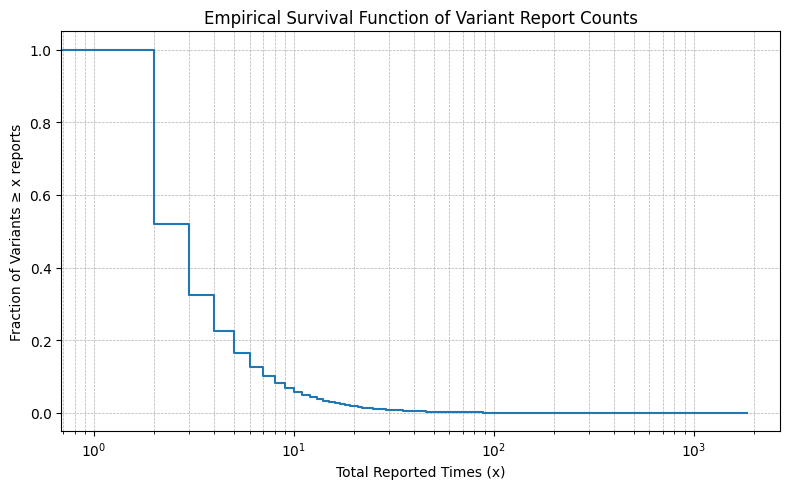

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Aggregate reported counts per unique variant
merged_reported = (
    vcf_final
    .groupby(['CHROM','POS','REF','ALT'], as_index=False)['REPORTED']
    .sum()
    .rename(columns={'REPORTED':'TOTAL_REPORTED'})
)

# 2) Get the array of total‐reported counts
data = merged_reported['TOTAL_REPORTED'].to_numpy()

# 3) Identify each unique report count and how many variants have that count
unique_vals, freq = np.unique(data, return_counts=True)

# 4) For each unique count x, compute how many variants have ≥ x reports
#    We do a reverse cumulative sum over freq
cum_ge = np.cumsum(freq[::-1])[::-1]

# 5) Convert to fraction of total variants
frac_ge = cum_ge / data.size

# 6) Plot the complementary CDF (“survival function”)
plt.figure(figsize=(8,5))
plt.step(unique_vals, frac_ge, where='post')
plt.xscale('log')
plt.xlabel('Total Reported Times (x)')
plt.ylabel('Fraction of Variants ≥ x reports')
plt.title('Empirical Survival Function of Variant Report Counts')
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()


### Consequence Pie Charts Before and After

<ipython-input-168-b1a9b9aab7e2>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20').colors  # 20 distinct colors


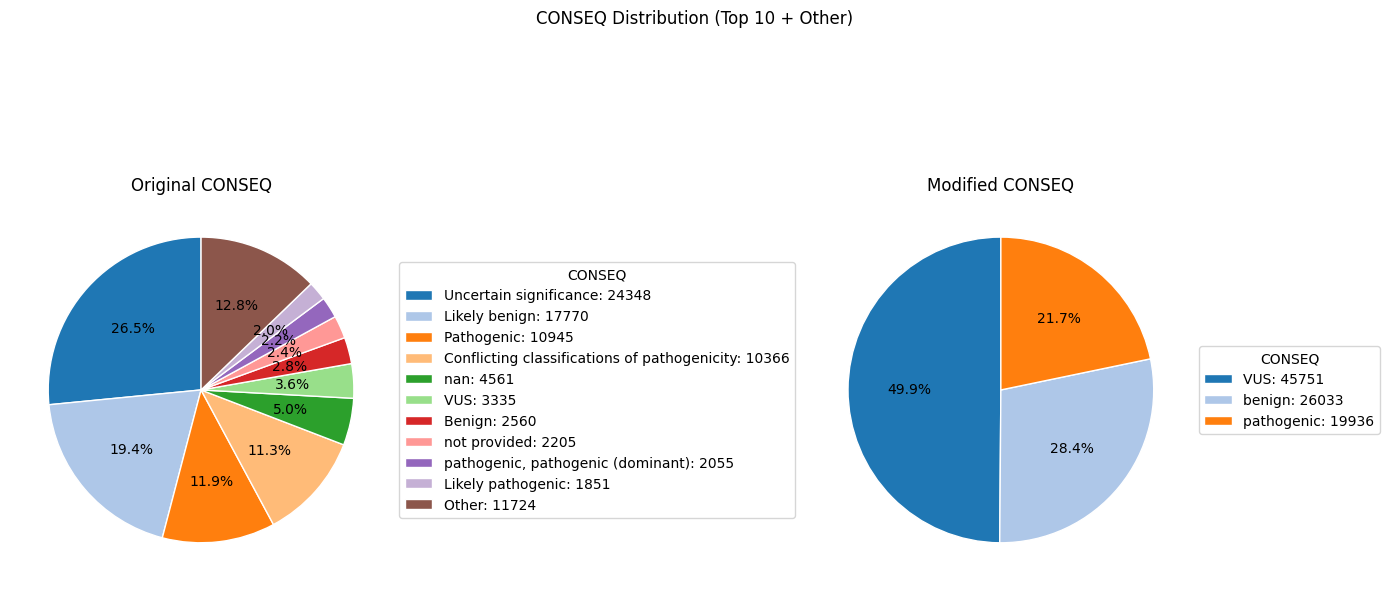

In [168]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Define palette using a contrasting qualitative colormap
palette = cm.get_cmap('tab20').colors  # 20 distinct colors

def prepare_counts(counts):
    top = counts.iloc[:10].copy()
    others = counts.iloc[10:].sum()
    if others > 0:
        top['Other'] = others
    return top

# Prepare top-10+Other series
orig_top = prepare_counts(original_conseq_counts)
mod_top = prepare_counts(modified_conseq_counts)

# Plot side-by-side pie charts
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

for ax, data, title in zip(axs, [orig_top, mod_top], ['Original CONSEQ', 'Modified CONSEQ']):
    # pick as many contrasting colors as needed
    colors = palette[:len(data)]
    wedges, texts, autotexts = ax.pie(
        data,
        labels=None,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'white'}
    )
    ax.set_title(title)
    # Create legend
    legend_labels = [f'{label}: {count}' for label, count in data.items()]
    ax.legend(
        wedges,
        legend_labels,
        title='CONSEQ',
        loc='center left',
        bbox_to_anchor=(1, 0.5)
    )

plt.suptitle('CONSEQ Distribution (Top 10 + Other)', y=1.02)
plt.tight_layout()
plt.show()


# Annotation Dataframe Processing and Analysis

In [169]:
# Make sure the key columns are strings
finalAnnot['Otherinfo6'] = finalAnnot['Otherinfo6'].astype(str)
vcf_final['ID']         = vcf_final['ID'].astype(str)

# Inner‐merge on ID: bring in every column from vcf_final, keep only rows present in vcf_final
merged = (
    finalAnnot
    .rename(columns={'Otherinfo6':'ID'})           # align column name
    .merge(vcf_final, on='ID', how='inner')         # inner join → only IDs in vcf_final
)

# If you no longer need the original Otherinfo6 column, it’s already been renamed to ID.
# `merged` now contains all columns from both dataframes, for IDs present in vcf_final.


In [170]:
merged

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,CHROM,POS,REF,ALT,FILTER,QUAL,CONSEQ,REPORTED,GENE,DB
0,17,32930564,32930935,TGCTCCTGCACAGGGATCCAGCAGGCAGAAGACACAGAGGTGTCAG...,-,intronic,TMEM132E,.,.,.,...,17,32930563,CTGCTCCTGCACAGGGATCCAGCAGGCAGAAGACACAGAGGTGTCA...,C,.,.,pathogenic,1,BRCA2,CV
1,17,41191488,41191488,G,A,intergenic,"RND2,BRCA1",dist=7430;dist=4824,.,.,...,17,41191488,G,A,.,.,benign,2,BRCA1,BOTH
2,17,41191835,41191835,G,A,intergenic,"RND2,BRCA1",dist=7777;dist=4477,.,.,...,17,41191835,G,A,.,.,benign,2,BRCA1,BOTH
3,17,41192016,41192016,-,AT,intergenic,"RND2,BRCA1",dist=7958;dist=4296,.,.,...,17,41192016,C,CAT,.,.,benign,1,BRCA1,CV
4,17,41192182,41192182,C,T,intergenic,"RND2,BRCA1",dist=8124;dist=4130,.,.,...,17,41192182,C,T,.,.,benign,2,BRCA1,BOTH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76600,7,152373212,152373212,C,T,UTR5,XRCC2,NM_005431:c.-48G>A,.,.,...,7,152373212,C,T,.,.,benign,1,XRCC2,CV
76601,7,152373214,152373214,C,T,UTR5,XRCC2,NM_005431:c.-50G>A,.,.,...,7,152373214,C,T,.,.,benign,1,XRCC2,CV
76602,7,152373233,152373233,A,C,upstream,XRCC2,dist=7,.,.,...,7,152373233,A,C,.,.,benign,2,XRCC2,CV
76603,7,152373252,152373252,C,G,upstream,XRCC2,dist=26,.,.,...,7,152373252,C,G,.,.,benign,2,XRCC2,CV


In [171]:
merged.shape

(76605, 138)

<ipython-input-172-b57dbdea5f5a>:47: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper left')


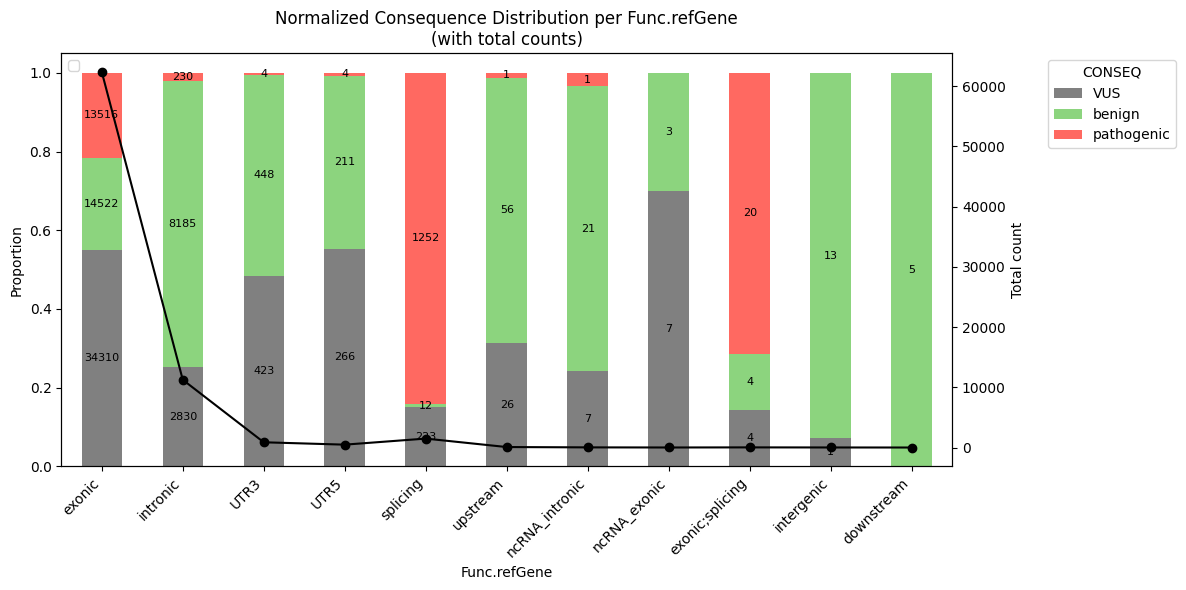

In [172]:
merged_df = merged.copy()
# (1) Grouping
grouped      = merged_df.groupby(['Func.refGene','CONSEQ']).size().unstack(fill_value=0)
grouped_sorted = grouped.sort_values(by=grouped.columns.tolist(), ascending=False)
grouped_normalized = grouped_sorted.div(grouped_sorted.sum(axis=1), axis=0)
totals = grouped_sorted.sum(axis=1)

# (2) Plot setup
fig, ax = plt.subplots(figsize=(12,6))
colors = {'pathogenic':'#FF6961','benign':'#8CD47E','VUS':'grey'}

bar_container = grouped_normalized.plot(
    kind='bar', stacked=True,
    color=[colors.get(c, 'lightgrey') for c in grouped_normalized.columns],
    ax=ax
)

# (3) Add counts to each segment
for idx, row in enumerate(grouped_sorted.index):
    y_offset = 0
    for col in grouped_sorted.columns:
        val = grouped_sorted.loc[row, col]
        if val > 0:
            height = grouped_normalized.loc[row, col]
            ax.text(
                idx, y_offset + height / 2,
                str(val),
                ha='center', va='center', fontsize=8, color='black'
            )
            y_offset += height

# (4) Overlay totals as a line
ax2 = ax.twinx()
ax2.plot(
    range(len(totals)), totals.values,
    color='black', marker='o', linestyle='-',
)
ax2.set_ylabel('Total count', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# (5) Final touches
ax.set_xlabel('Func.refGene')
ax.set_ylabel('Proportion')
ax.set_title('Normalized Consequence Distribution per Func.refGene\n(with total counts)')
ax.set_xticklabels(grouped_normalized.index, rotation=45, ha='right')
ax.legend(title='CONSEQ', bbox_to_anchor=(1.1,1))
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()

<ipython-input-173-c3c2717e9668>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper left')


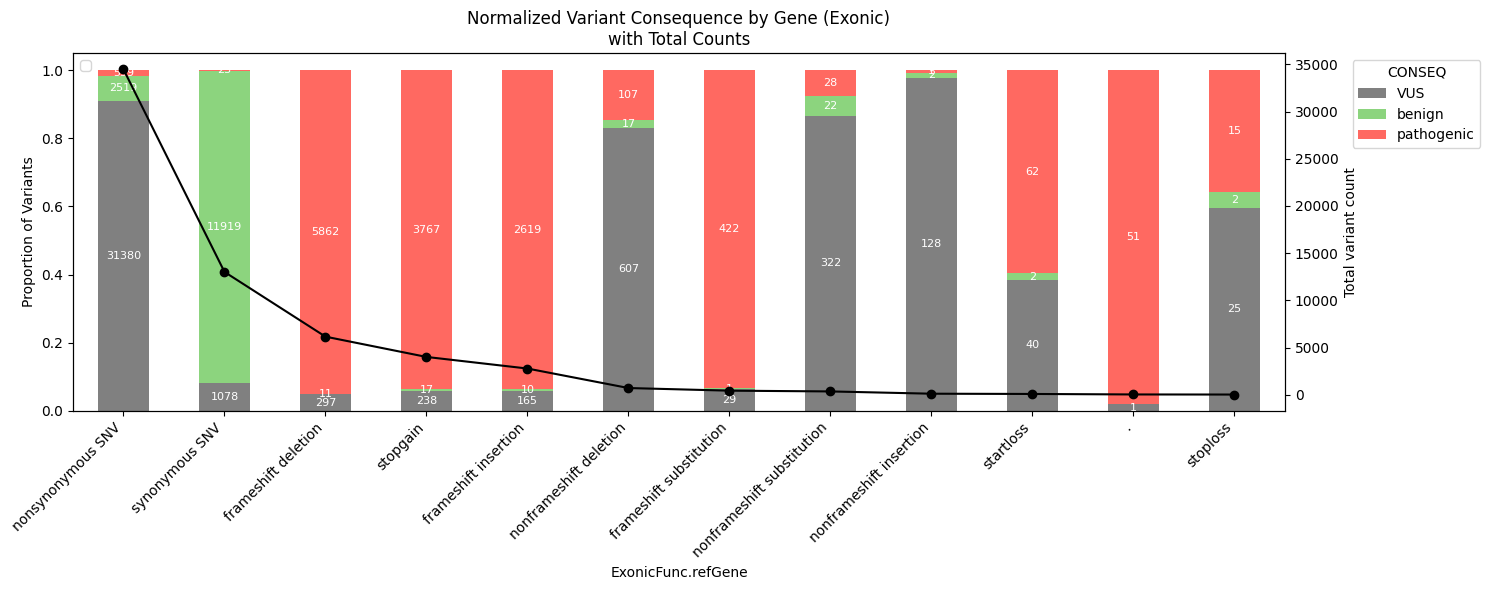

In [173]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter for exonic variants
exonic_df = merged[merged['Func.refGene'] == 'exonic']

# Group by ExonicFunc.refGene and CONSEQ to get absolute counts
grouped_counts = exonic_df.groupby(['ExonicFunc.refGene', 'CONSEQ']).size().unstack(fill_value=0)

# Define colors for each consequence category
colors = {'pathogenic': '#FF6961', 'benign': '#8CD47E', 'VUS': 'grey'}

# Sort by total variant count per gene
grouped_counts['Total'] = grouped_counts.sum(axis=1)
grouped_counts = grouped_counts.sort_values(by='Total', ascending=False).drop(columns=['Total'])

# Normalize for plotting proportions
grouped_counts_normalized = grouped_counts.div(grouped_counts.sum(axis=1), axis=0)

# Plot normalized stacked bar chart
fig, ax = plt.subplots(figsize=(15, 6))
grouped_counts_normalized.plot(
    kind='bar', stacked=True,
    color=[colors[conseq] for conseq in grouped_counts_normalized.columns],
    ax=ax
)

# Annotate each segment with the absolute count
for idx, gene in enumerate(grouped_counts.index):
    bottom = 0
    for conseq in grouped_counts.columns:
        prop = grouped_counts_normalized.loc[gene, conseq]
        if prop > 0:
            count = grouped_counts.loc[gene, conseq]
            ax.text(
                idx,
                bottom + prop / 2,
                str(count),
                ha='center',
                va='center',
                fontsize=8,
                color='white'
            )
            bottom += prop

# Overlay the total counts as a line on a secondary y-axis
totals = grouped_counts.sum(axis=1)
ax2 = ax.twinx()
ax2.plot(
    range(len(totals)), totals.values,
    color='black', marker='o', linestyle='-',

)
ax2.set_ylabel('Total variant count', color='black')
ax2.tick_params(axis='y', labelcolor='black')
ax2.legend(loc='upper left')

# Final plot adjustments
ax.set_xlabel('ExonicFunc.refGene')
ax.set_ylabel('Proportion of Variants')
ax.set_title('Normalized Variant Consequence by Gene (Exonic)\nwith Total Counts')
ax.set_xticklabels(grouped_counts.index, rotation=45, ha='right')
ax.legend(title='CONSEQ', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [174]:
# prompt: merged where 'ExonicFunc.refGene' contains nonsynonymous and CONSEQ is pathogenic

# Assuming 'merged_df' is already defined from the previous code

# Filter for rows where 'ExonicFunc.refGene' contains 'nonsynonymous' and 'CONSEQ' is 'pathogenic'
merged_filtered_syn = merged_df[
    (merged_df['ExonicFunc.refGene'] == 'synonymous SNV') &
    (merged_df['CONSEQ'].str.lower() == 'pathogenic')
]

# Display the filtered DataFrame
merged_filtered_syn['GENE'].value_counts()


,count
GENE,
BRCA2,6
BRCA1,5
FANCA,5
PALB2,4
FANCC,2
BRIP1,1
FANCD2,1
FANCL,1


In [175]:
merged_filtered_non = merged_df[
    (merged_df['ExonicFunc.refGene'] == 'nonsynonymous SNV')
]

# Display the filtered DataFrame
merged_filtered_non.to_csv('merged.tsv', sep='\t', index=False)

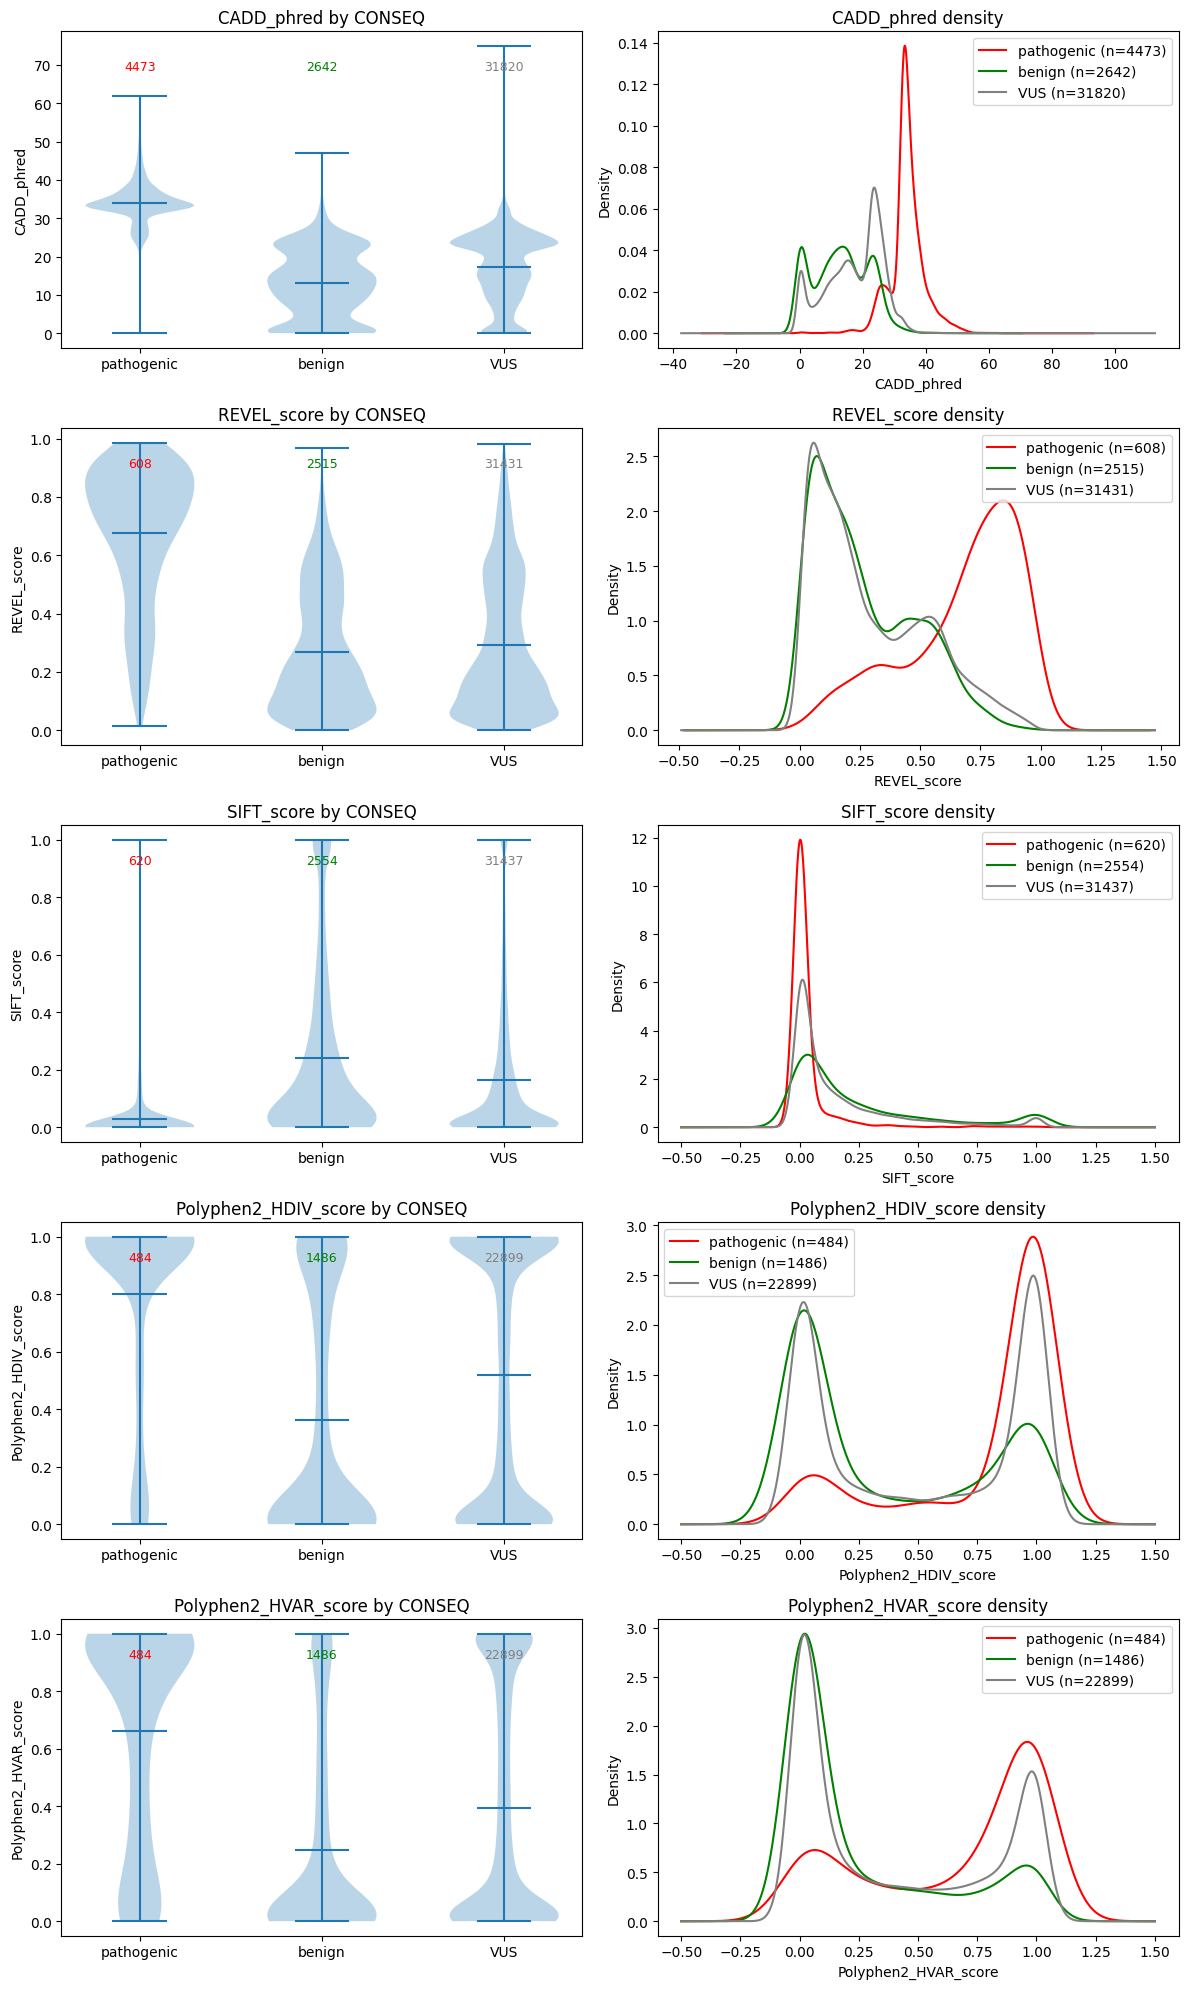

In [176]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# Define CONSEQ categories and colors
categories = ['pathogenic', 'benign', 'VUS']
colors = {'pathogenic': 'red', 'benign': 'green', 'VUS': 'grey'}

# Subset to only those categories
df = merged_df[merged_df['CONSEQ'].isin(categories)].copy()
df['CONSEQ'] = pd.Categorical(df['CONSEQ'], categories=categories, ordered=True)

# Predictors to examine (ensure columns exist)
predictors = [c for c in ['CADD_phred', 'REVEL_score', 'SIFT_score',
                          'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score'] if c in df]

# Convert predictor columns to numeric once for all operations
for p in predictors:
    df[p] = pd.to_numeric(df[p], errors='coerce')

# Drop rows missing all predictors
df_clean = df.dropna(subset=predictors, how='all')

# Pre-compute maximum values to position the count labels
max_vals = {p: df_clean[p].max(skipna=True) or 1 for p in predictors}

# Create subplots: one row per predictor, two columns
n = len(predictors)
fig, axes = plt.subplots(n, 2, figsize=(12, 4 * n))
if n == 1:
    axes = np.array([axes])

for i, predictor in enumerate(predictors):
    ax_violin, ax_density = axes[i]

    # Data for each category
    data = [df_clean[df_clean['CONSEQ'] == cat][predictor].dropna() for cat in categories]

    # Violin plot
    ax_violin.violinplot(data, positions=range(len(categories)), showmeans=True, widths=0.6)
    ax_violin.set_xticks(range(len(categories)))
    ax_violin.set_xticklabels(categories)
    ax_violin.set_ylabel(predictor)
    ax_violin.set_title(f'{predictor} by CONSEQ')

    # Label counts above each violin
    for pos, cat in enumerate(categories):
        count = len(data[pos])
        y_pos = max_vals[predictor] * 0.95
        ax_violin.text(pos, y_pos, str(count), ha='center', va='top', fontsize=9, color=colors[cat])

    # Density plots
    for cat in categories:
        series = df_clean[df_clean['CONSEQ'] == cat][predictor].dropna()
        if not series.empty:
            series.plot.kde(ax=ax_density, label=f'{cat} (n={len(series)})', color=colors[cat])
    ax_density.set_title(f'{predictor} density')
    ax_density.set_xlabel(predictor)
    ax_density.legend()

plt.tight_layout()
plt.show()


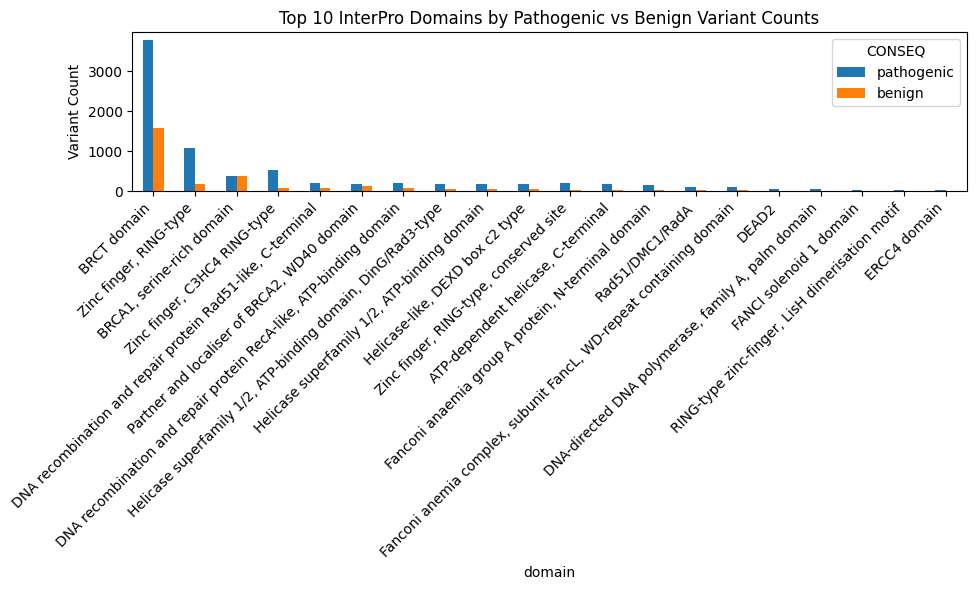

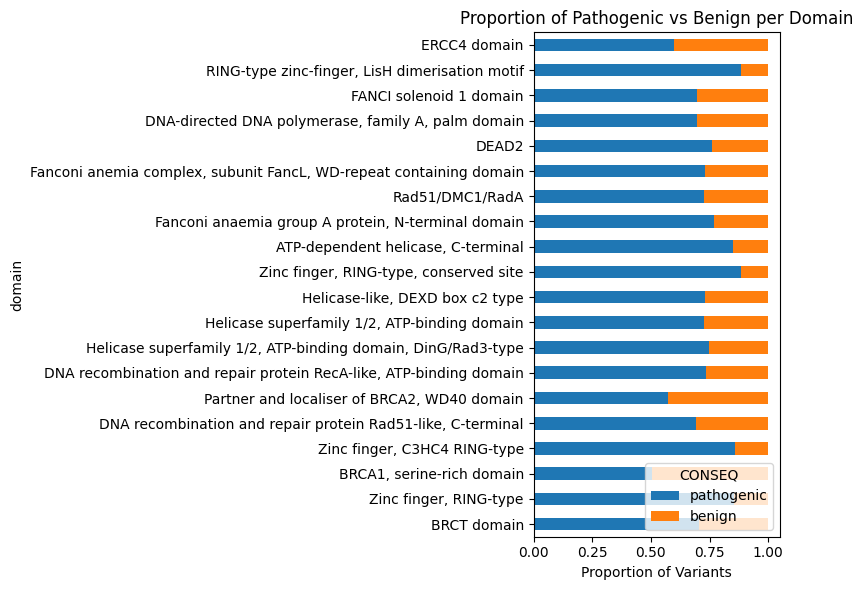

In [177]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Clean & explode domains
df = merged_df[['Interpro_domain', 'CONSEQ']].dropna()
df['Interpro_domain'] = df['Interpro_domain'].astype(str).str.replace(';', '|')
exploded = df.assign(domain=df['Interpro_domain'].str.split('|')).explode('domain')
exploded['domain'] = exploded['domain'].str.strip()
exploded = exploded[exploded['domain'].notnull() & ~exploded['domain'].isin(['', '.'])]

# 2. Pivot to get pathogenic & benign counts
pivot = exploded.groupby(['domain', 'CONSEQ']).size().unstack(fill_value=0)
# Ensure both columns exist
for col in ['pathogenic', 'benign']:
    if col not in pivot.columns:
        pivot[col] = 0
counts = pivot[['pathogenic', 'benign']]

# 3. Select top 10 domains by total variants
top10 = counts.sum(axis=1).nlargest(20).index
counts_top = counts.loc[top10]

# 4. Grouped bar chart (absolute counts)
fig, ax = plt.subplots(figsize=(10, 6))
counts_top.plot(kind='bar', ax=ax)
ax.set_ylabel('Variant Count')
ax.set_title('Top 10 InterPro Domains by Pathogenic vs Benign Variant Counts')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 5. Stacked 100% bar chart (proportions)
props = counts_top.div(counts_top.sum(axis=1), axis=0)
fig, ax = plt.subplots(figsize=(8, 6))
props.plot(kind='barh', stacked=True, ax=ax)
ax.set_xlabel('Proportion of Variants')
ax.set_title('Proportion of Pathogenic vs Benign per Domain')
ax.legend(title='CONSEQ', loc='lower right')
plt.tight_layout()
plt.show()


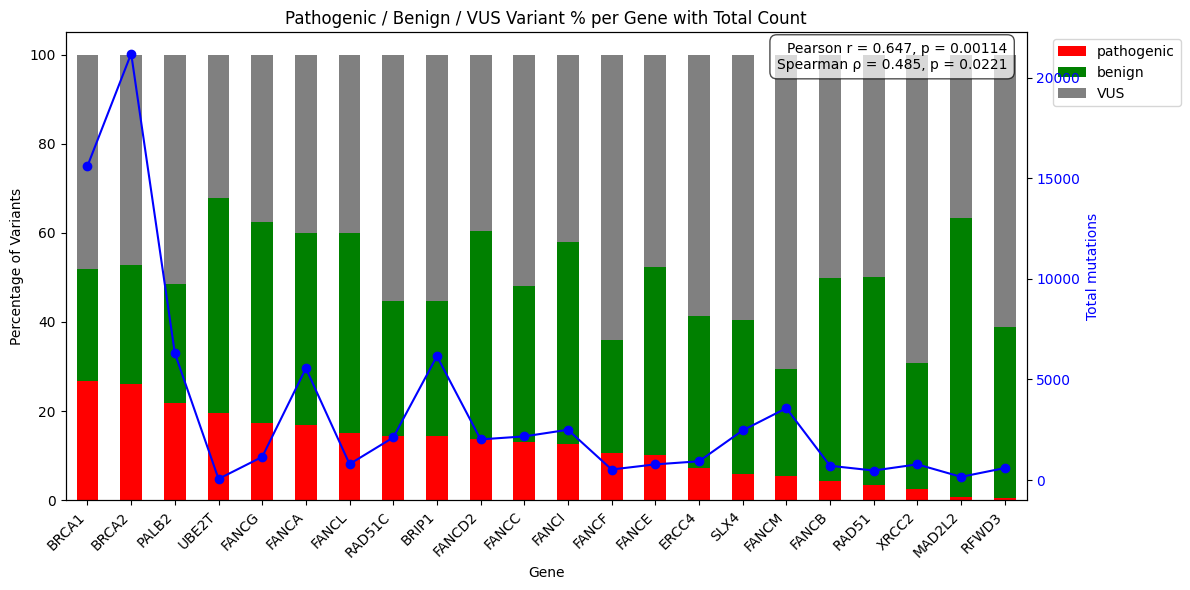

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# your list of 22 FANC genes
genes_of_interest = [
    "FANCA","FANCB","FANCC","BRCA2","FANCD2","FANCE","FANCF","FANCG",
    "FANCI","BRIP1","FANCL","FANCM","PALB2","RAD51C","SLX4","ERCC4",
    "RAD51","BRCA1","UBE2T","XRCC2","MAD2L2","RFWD3"
]

# filter
filtered = merged_df

# count per gene × consequence
counts = (filtered
          .groupby(['GENE','CONSEQ'])
          .size()
          .unstack(fill_value=0))

# convert to percentages
pct = counts.div(counts.sum(axis=1), axis=0) * 100

# select and order only the three CONSEQ categories
pct = pct[['pathogenic','benign','VUS']]

# sort by pathogenic descending
pct = pct.sort_values('pathogenic', ascending=False)

# define colors
colors = {'pathogenic': 'red', 'benign': 'green', 'VUS': 'grey'}

total_counts = counts.sum(axis=1)
percent_pathogenic = pct['pathogenic']

# Compute correlations
total_counts = counts.sum(axis=1)
percent_pathogenic = pct['pathogenic']
r, p_value = pearsonr(total_counts, percent_pathogenic)
rho, p_spearman = spearmanr(total_counts, percent_pathogenic)

# Plotting
fig, ax = plt.subplots(figsize=(12,6))
pct.plot(kind='bar', stacked=True, ax=ax, color=[colors[c] for c in pct.columns])

ax2 = ax.twinx()
ax2.plot(range(len(total)), total.values, color='blue', marker='o', linestyle='-')
ax2.set_ylabel('Total mutations', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax.set_ylabel('Percentage of Variants')
ax.set_xlabel('Gene')
ax.set_title('Pathogenic / Benign / VUS Variant % per Gene with Total Count')
ax.set_xticklabels(pct.index, rotation=45, ha='right')

# Build stats text
stats_text = (
    f"Pearson r = {r:.3f}, p = {p_value:.3g}\n"
    f"Spearman ρ = {rho:.3f}, p = {p_spearman:.3g}"
)

# Draw stats on the plot (upper right corner of the bar axis)
ax.text(
    0.98, 0.98, stats_text,
    transform=ax.transAxes,
    ha='right', va='top',
    bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7)
)

# Merge legends
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, bbox_to_anchor=(1.02,1), loc='upper left')

plt.tight_layout()
plt.show()


In [179]:
vcf_final.to_csv('vcf_final.tsv', sep='\t', index=False)

In [193]:
# prompt: for each 'GENE' column in merged_df show top 3 variants by 'REPORTED' whose 'CONSEQ' are pathogenic, also show the number of reports as percentage of all reported for that gene, show also total reports, only return ID, Number of Reports, Percentage of total, total. also include ExonicFunc.refGene and Func.refGene columns

import pandas as pd

# Assuming merged_df is already defined from the previous code

def top_variants_by_gene(merged_df):
    """
    For each 'GENE' in merged_df, shows top 3 variants by 'REPORTED'
    whose 'CONSEQ' are pathogenic, the number of reports as a percentage
    of all reported for that gene, the total reports, and relevant columns.
    """

    results = []
    for gene, gene_df in merged_df.groupby('GENE'):
        pathogenic_variants = gene_df[gene_df['CONSEQ'].str.lower() == 'pathogenic']
        if not pathogenic_variants.empty:
            # Sort by 'REPORTED' in descending order and take the top 3
            top_variants = pathogenic_variants.nlargest(10, 'REPORTED')

            for index, row in top_variants.iterrows():
                total_reports_for_gene = gene_df['REPORTED'].sum()
                percentage = (row['REPORTED'] / total_reports_for_gene) * 100 if total_reports_for_gene > 0 else 0

                results.append([
                    row['ID'],
                    row['REPORTED'],
                    f"{percentage:.2f}%",  # Format percentage to 2 decimal places
                    total_reports_for_gene,
                    row['ExonicFunc.refGene'],
                    row['Func.refGene'],
                    row['CONSEQ'],
                    row['GENE'],
                    row['AAChange.refGene']
                ])

    return pd.DataFrame(results, columns=['ID', 'Number of Reports', 'Percentage of total', 'Total', 'ExonicFunc.refGene', 'Func.refGene','CONSEQ','GENE','AAChange.refGene	'])

# Example usage (replace with your actual DataFrame)
top_variants_df = top_variants_by_gene(merged_df)
top_variants_df


,ID,Number of Reports,Percentage of total,Total,ExonicFunc.refGene,Func.refGene,CONSEQ,GENE,AAChange.refGene\t
0,CV.BRCA100004,336,0.42%,80752,frameshift deletion,exonic,pathogenic,BRCA1,"BRCA1:NM_007298:exon1:c.68_69del:p.E23Vfs*17,B..."
1,CV.BRCA100908,279,0.35%,80752,frameshift deletion,exonic,pathogenic,BRCA1,BRCA1:NM_007297:exon9:c.2544_2545del:p.P850Kfs...
2,CV.BRCA100276,263,0.33%,80752,.,splicing,pathogenic,BRCA1,.
3,CV.BRCA100014,174,0.22%,80752,stopgain,exonic,pathogenic,BRCA1,"BRCA1:NM_007297:exon11:c.C4186T:p.R1396X,BRCA1..."
4,CV.BRCA100310,164,0.20%,80752,frameshift insertion,exonic,pathogenic,BRCA1,"BRCA1:NM_007298:exon1:c.66dupA:p.E23Rfs*18,BRC..."
...,...,...,...,...,...,...,...,...,...
199,CV.XRCC200659,1,0.07%,1465,stopgain,exonic,pathogenic,XRCC2,XRCC2:NM_005431:exon3:c.T539G:p.L180X
200,CV.XRCC200224,1,0.07%,1465,frameshift deletion,exonic,pathogenic,XRCC2,XRCC2:NM_005431:exon3:c.490_491del:p.E164Kfs*22
201,CV.XRCC200428,1,0.07%,1465,frameshift insertion,exonic,pathogenic,XRCC2,XRCC2:NM_005431:exon3:c.488dupG:p.E164Rfs*23
202,CV.XRCC200584,1,0.07%,1465,stopgain,exonic,pathogenic,XRCC2,XRCC2:NM_005431:exon3:c.C395A:p.S132X


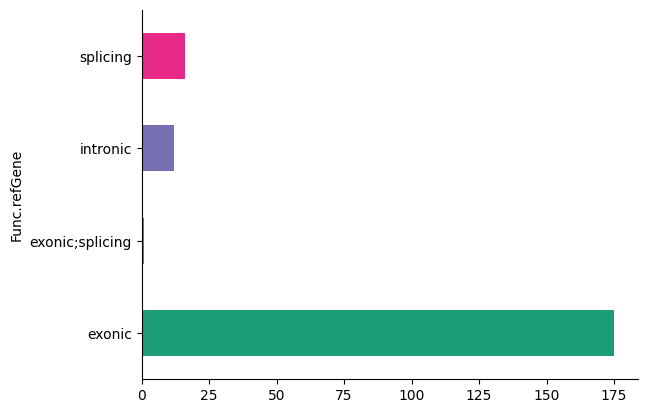

In [189]:
# @title ExonicFunc.refGene

from matplotlib import pyplot as plt
import seaborn as sns
top_variants_df.groupby('Func.refGene').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [182]:
# prompt: merged dataframe where ID contains FANCI

# Assuming vcf_final DataFrame is already created as in the provided code.

# Filter the vcf_final DataFrame to include only rows where the 'ID' column contains 'FANCI'
fanci_variants = merged[merged['ID'].str.contains('FANCI00270')]

# Display or further process the filtered DataFrame
fanci_variants


,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,CHROM,POS,REF,ALT,FILTER,QUAL,CONSEQ,REPORTED,GENE,DB
70134,15,89838198,89838198,G,T,exonic,FANCI,.,stopgain,"FANCI:NM_001113378:exon24:c.G2509T:p.E837X,FAN...",...,15,89838198,G,T,.,.,pathogenic,8,FANCI,BOTH


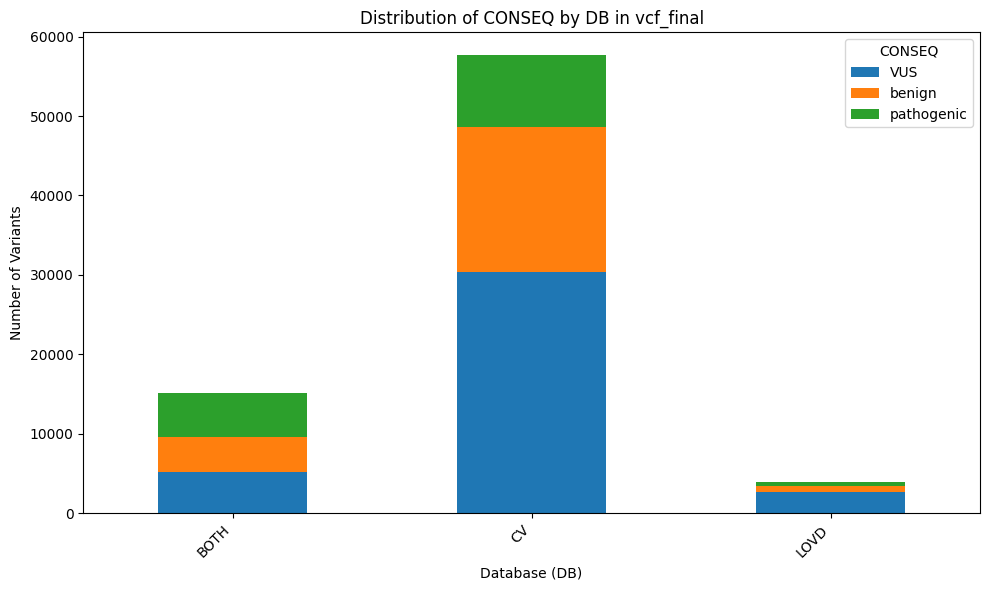

In [183]:
# prompt: distribution of CONSEQ by DB in vcf_final

# Assuming vcf_final is already defined as in the provided code.
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'DB' and 'CONSEQ' and get the counts
conseq_by_db = vcf_final.groupby(['DB', 'CONSEQ']).size().unstack(fill_value=0)

# Plotting the distribution
conseq_by_db.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Distribution of CONSEQ by DB in vcf_final')
plt.xlabel('Database (DB)')
plt.ylabel('Number of Variants')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='CONSEQ')
plt.tight_layout()
plt.show()


In [186]:
# prompt: sort merged by "REPORTED" and show top 10

# Sort the vcf_final DataFrame by the 'REPORTED' column in descending order and display the top 10 rows.
top_10_reported = vcf_final.sort_values('REPORTED', ascending=False).head(10)
top_10_reported


,CHROM,POS,ID,REF,ALT,FILTER,QUAL,CONSEQ,REPORTED,GENE,DB
65379,13,32936646,CV.BRCA202979,T,C,.,.,benign,1852,BRCA2,BOTH
66026,13,32953388,CV.BRCA202997,T,C,.,.,benign,1588,BRCA2,BOTH
69691,17,41244936,CV.BRCA100340,G,A,.,.,benign,1587,BRCA1,BOTH
75634,17,41244000,CV.BRCA100346,T,C,.,.,benign,1530,BRCA1,BOTH
69999,17,41245466,CV.BRCA102275,G,A,.,.,benign,1521,BRCA1,BOTH
75666,17,41244435,CV.BRCA100343,T,C,.,.,benign,1519,BRCA1,BOTH
69881,17,41245237,CV.BRCA102284,A,G,.,.,benign,1510,BRCA1,BOTH
68692,17,41234470,CV.BRCA102373,A,G,.,.,benign,1468,BRCA1,BOTH
75520,17,41223094,CV.BRCA100355,T,C,.,.,benign,1467,BRCA1,BOTH
63174,13,32911888,CV.BRCA202889,A,G,.,.,benign,1269,BRCA2,BOTH


In [195]:
top_variants_df[top_variants_df['ID'].str.contains('FANCM')].to_csv('fancm.tsv', sep='\t', index=False)
top_variants_df[top_variants_df['ID'].str.contains('FANCI')].to_csv('fanci.tsv', sep='\t', index=False)
#

In [191]:
merged

,Chr,Start,End,Ref,Alt,Func.refGene,Gene.refGene,GeneDetail.refGene,ExonicFunc.refGene,AAChange.refGene,...,CHROM,POS,REF,ALT,FILTER,QUAL,CONSEQ,REPORTED,GENE,DB
0,17,32930564,32930935,TGCTCCTGCACAGGGATCCAGCAGGCAGAAGACACAGAGGTGTCAG...,-,intronic,TMEM132E,.,.,.,...,17,32930563,CTGCTCCTGCACAGGGATCCAGCAGGCAGAAGACACAGAGGTGTCA...,C,.,.,pathogenic,1,BRCA2,CV
1,17,41191488,41191488,G,A,intergenic,"RND2,BRCA1",dist=7430;dist=4824,.,.,...,17,41191488,G,A,.,.,benign,2,BRCA1,BOTH
2,17,41191835,41191835,G,A,intergenic,"RND2,BRCA1",dist=7777;dist=4477,.,.,...,17,41191835,G,A,.,.,benign,2,BRCA1,BOTH
3,17,41192016,41192016,-,AT,intergenic,"RND2,BRCA1",dist=7958;dist=4296,.,.,...,17,41192016,C,CAT,.,.,benign,1,BRCA1,CV
4,17,41192182,41192182,C,T,intergenic,"RND2,BRCA1",dist=8124;dist=4130,.,.,...,17,41192182,C,T,.,.,benign,2,BRCA1,BOTH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76600,7,152373212,152373212,C,T,UTR5,XRCC2,NM_005431:c.-48G>A,.,.,...,7,152373212,C,T,.,.,benign,1,XRCC2,CV
76601,7,152373214,152373214,C,T,UTR5,XRCC2,NM_005431:c.-50G>A,.,.,...,7,152373214,C,T,.,.,benign,1,XRCC2,CV
76602,7,152373233,152373233,A,C,upstream,XRCC2,dist=7,.,.,...,7,152373233,A,C,.,.,benign,2,XRCC2,CV
76603,7,152373252,152373252,C,G,upstream,XRCC2,dist=26,.,.,...,7,152373252,C,G,.,.,benign,2,XRCC2,CV
